# En las siguientes celdas se cargan los datos siguiendo el tutorial

In [1]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [2]:
# cargar datos
with open("shipsnet.json", "r") as f:
    dataset = json.load(f)
print(dataset.keys())

dict_keys(['data', 'labels', 'locations', 'scene_ids'])


In [3]:
# llevar las imagenes aplanadas a 80x80x3
data = np.array(dataset['data']).astype('uint8')
data = data.reshape(-1,3,80,80).transpose([0,2,3,1])
labels =  np.array(dataset['labels'])

print(f"Dimensión: {data.shape}")

# llevamos las imágenes RGB a escala de grises
data_gray = np.array([color.rgb2gray(i) for i in data])
print(f"Dimensión: {data_gray.shape}")

Dimensión: (4000, 80, 80, 3)
Dimensión: (4000, 80, 80)


In [4]:
# extrae hog features y hog transformation para cada imagen
ppc = 20
hog_images = []
hog_features = []
for image in data_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc), cells_per_block=(1, 1),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)
hog_features = np.array(hog_features)
hog_images = np.array(hog_images)

hog_features.shape


(4000, 128)

In [5]:
print(np.array(dataset["labels"]).size)
print(data.shape)

4000
(4000, 80, 80, 3)


# Se discrimina entre datos de entrenamiento, validación y para testear

$70$% entrenamiento, $15$% validación y $15$% para testear

In [6]:
x_train, x_resto, y_train, y_resto = train_test_split(hog_features, labels, test_size=0.3, random_state=12)
x_val, x_test, y_val, y_test = train_test_split(x_resto, y_resto, test_size=0.5, random_state=12)

# Funciones útiles

In [7]:
def sigma(w, x):
    """
    Calcula sigma(w.x)
    w y x son arreglos numéricos de igual largo.
    """
    return 1 / (1 + np.exp(-np.dot(w, x)))

def logVerTrain(w):
    """
    Calcula log-verosimilitud de w con datos de entrenamiento.
    w: arreglo numérico.
    """
    N = len(w)
    return sum(y_train[i] * np.log(sigma(w, x_train[i])) + 
                                    (1 - y_train[i]) * np.log(1 - sigma(w, x_train[i])) for i in range(N)) 

def logVerVal(w):
    """
    Calcula log-verosimilitud de w con datos de validación.
    w: arreglo numérico.
    """
    N = len(w)
    return sum(y_val[i] * np.log(sigma(w, x_val[i])) + (1 - y_val[i]) * np.log(1 - sigma(w, x_train[i]))                     for i in range(N))

def logVerTest(w):
    """
    Calcula log-verosimilitud de w con datos de testeo.
    w: arreglo numérico.
    """
    N = len(w)
    return sum(y_test[i] * np.log(sigma(w, x_test[i])) + (1 - y_test[i]) * np.log(1 - sigma(w, x_test[i]))                 for i in range(N)) 

# Clase que hará la regresión 

In [8]:
class RegLog:
    def __init__(self, xData, yData):
        
        self.xData = xData
        self.yData = yData
        self.N = len(yData)
        self.dim = len(xData[0])
        
    def sigma(self, w, i):
        """
        Método que calcula sigma(w.x)
        w: arreglo de largo N.
        i: índice del vector de interés.
        """
        return sigma(w, self.xData[i])
                    
    def pasada(w_0, eta):
        """
        Método que realiza una pasada por todos los datos del GSD.
        w_0: punto inicial de la pasada. 
        eta: learning rate.
        """
        W = [w_0]
        #ind = np.arange(self.N)
        #np.random.shuffle(ind)
        for i in np.arange(self.N):
            a = W[i] + eta * (self.yData[i] - self.sigma(W[i], i)) * self.xData[i]
            W.append(a)
        return W[self.N]

    
    def maxVer(self, genMax, eta):
        """
        Maximiza versimilitud con GSD.
        genMax: Número máximo de generaciones.
        eta: learning rate.
        return: 3 arreglos que guardan la función de verosimilitud.
        """
        # Arreglos que guardarán las maximas verosimilitudes alcanzadas hasta cierta época.
        train = []
        val = []
        test =[]
        # Optimización.
        init = np.ones(self.dim)
        ti = time.time()
        for i in np.arange(1, genMax + 1):
            newInit = pasada(init, eta)
            init = newInit
            if i % 1 == 0:
                train.append(logVerTrain(init))
                val.append(logVerVal(init))
                test.append(logVerTest(init))
        tf = time.time()    
        print("Generaciones: " + str(genMax) + ', eta: ' +  str(eta) +", tiempo (s): ", tf - ti)
        return [np.array(train), np.array(val), np.array(test)]
    


              
            


# Se generan gráficas.

Generaciones: 100, eta: 0.01, tiempo (s):  21.697555780410767
Generaciones: 100, eta: 0.05, tiempo (s):  22.256218433380127
Generaciones: 100, eta: 0.1, tiempo (s):  21.457706451416016
Generaciones: 100, eta: 0.6, tiempo (s):  24.24298596382141
Generaciones: 100, eta: 0.001, tiempo (s):  23.774267435073853


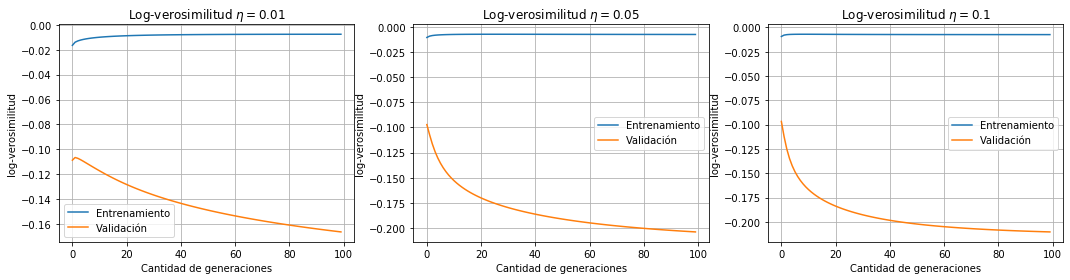

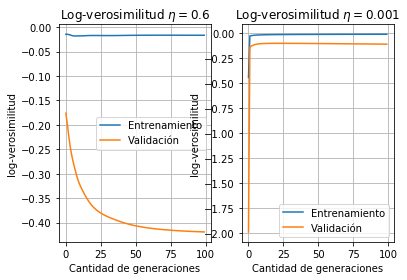

In [13]:
# Se crea objeto encargado de la regresión.
reg = RegLog(x_train, y_train)
N_train = reg.N
N_val = len(x_val)

# Plots.
def plotLogVerVsGen():
    """
    Plotea la log-verosimilitud en función de la cantidad de generaciones.
    """
    eta = [0.01, 0.05, 0.1, 0.6, 0.001]
    A = [[], [], [], [], []]
    A[0] = reg.maxVer(100, 0.01)
    A[1] = reg.maxVer(100, 0.05)
    A[2] = reg.maxVer(100, 0.1)
    # Casos extremos
    A[3] = reg.maxVer(100, 0.6)
    A[4] = reg.maxVer(100, 0.001)
    k = len(A[0][0])
    x = np.arange(k)
    fig = plt.figure(figsize=(18, 4))

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.plot(x, A[i][0] * (1 / N_train), label='Entrenamiento')
        plt.plot(x, A[i][1] * (1 / N_val), label='Validación')
        plt.title(r'Log-verosimilitud $\eta=$'+str(eta[i]))
        plt.xlabel('Cantidad de generaciones')
        plt.ylabel('log-verosimilitud')
        plt.grid()
        plt.legend()

    plt.show()

    for i in [3, 4]:
        x = np.arange(len(A[3][0]))
        plt.subplot(1, 2, i - 2)
        plt.plot(x, A[i][0] * (1 / N_train), label='Entrenamiento')
        plt.plot(x, A[i][1] * (1 / N_val), label='Validación')
        plt.title(r'Log-verosimilitud $\eta=$'+str(eta[i]))
        plt.xlabel('Cantidad de generaciones')
        plt.ylabel('log-verosimilitud')
        plt.grid()
        plt.legend()

    plt.show()

   

  




plotLogVerVsGen()

In [ ]:
class Fisher:
    def __init__ Fisher(self, xData, yData):
        self.xData = xData
        self.yData = yData
        self.N = len(xData)
        self.dim = len(xData[0])
        ship = np.zeros(self.dim)
        N1 = 0
        noShip = np.zeros(self.dim)
        N2 = 0
        for i in range(len(xData)):
            if yData[i] == 1:
                N1++
                ship = ship + xData[i]
            else:
                noShip = noShip + xData[i]
                N2++
        self.shipMean = ship / N1
        self.noShipMean = noShip / N2 

